<a href="https://colab.research.google.com/github/tatianamgar/Work_GPN/blob/main/ML%20Prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install --upgrade openpyxl

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ai-service')

In [ ]:
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pipeline import Pipeline
from tqdm import tqdm, trange
import re
import glob

### Getting predictions and marks for future definition

In [ ]:
def generate_df(predictions, data):
    columns = ['word', 'label', 'confidence', 'values', 'start_mark']
    results = pd.DataFrame(predictions, columns=columns).explode(column=columns)
    results = pd.merge(results, data, left_index=True, right_index=True)
    return results.reset_index().rename(columns={'index': 'code'})

In [ ]:
dir = '/content/drive/MyDrive/Выгрузки/'
dir_2 = '/content/drive/MyDrive/предикты и маркировки/'
files_path = glob.glob(dir + '*.xlsx')

pipeline = Pipeline(device='cuda')

for path in tqdm(files_path):
    data = pd.read_excel(path)
    class_name = os.path.basename(path).split(' ')[0]
    data['class'] = class_name
    data = data.dropna(subset=['Полное наименование ru']).reset_index(drop=True)
    
    print(f"Начинаю подсчет предиктов класса {class_name}")
    data_list = data['Полное наименование ru'].apply(lambda x: x.lower()).to_list()
    predictions = pipeline.predict(data_list)

    print(f"подсчет предиктов класса {class_name} окончен, готовлю таблицы")
    predictions = generate_df(predictions, data)
    predictions.to_excel(f'{dir_2}{class_name} предикты.xlsx')

    print(f"Предикты класса {class_name} сохранены. Начинаю процесс по маркировкам!")

    marks_prep = predictions[(predictions['label'] == 'маркировка') & 
                    (predictions['confidence']>0.7)].groupby(by=['word', 'Полное наименование ru'], 
                                                         as_index=False).max()

    marks_prep2 = predictions[(predictions['label'] == 'маркировка') & 
                     (predictions['confidence']>0.7)].groupby(by=['word'], as_index=False).count()
    marks_prep2 = marks_prep2[marks_prep2['code']>=5].sort_values(by=['code'], ascending=False)

    marks_prep['code'] = marks_prep['code'].apply(lambda x: int(x))
    marks_prep2['code'] = marks_prep2['code'].apply(lambda x: int(x))

    marks = pd.merge(marks_prep2, marks_prep, on=['word']).groupby(by=['word'], as_index=False).max()

    marks = marks.sort_values(by=['code_x'], 
                                        ascending=False)[['word', 'Полное наименование ru_y']]
    marks.to_excel(f'{dir_2}{class_name} маркировки.xlsx')
    print(f"Маркировки класса {class_name} сохранены. Начинаю процесс по след. классу!")

### DRAFT


In [ ]:
def reading(data):
  df = pd.read_excel(f"{dir}{data}")
  return df  

def saving_predicts(data):
  data.to_excel(f'{dir2}{separated[0]} предикты.xlsx')

def saving_marks(data):
  data.to_excel(f'{dir2}{separated[0]} маркировки.xlsx', index=None)


In [ ]:
dir = '/content/'
dir2 = '/content/drive/MyDrive/предикты и маркировки/'
concat_df = pd.DataFrame(columns=["word", 'label',"sentence", "class"])


for file in tqdm(os.listdir(dir)):
  if file.endswith(".xlsx"):
    data = reading(file)

    separated = re.split(" ", file)
    data["class"] = separated[0]

    data = data.dropna(subset = ['Полное наименование ru'])
    data_list = list(data['Полное наименование ru'].apply(lambda p: p.lower()))

    all_results = pd.DataFrame(['', '', '', '']).T
    all_results = all_results.head(0)
    all_results.columns = ('word', 'label', 'confidence', 'code')

    print(f"Начинаю подсчет предиктов класса {separated[0]}")
    a = [(predict.make_batch_prediction(data_list[i:i+1]), 
          [str(i)]) for i in range(len(data_list))]

    data['code'] = np.arange(len(data))
    data['code'] = data['code'].apply(lambda x: str(x))

    print(f"подсчет предиктов класса {separated[0]} окончен, готовлю таблицы")

    a_word_all = []
    a_label_all = []
    a_conf_all = []
    a_values_all = []
    a_step_all = []

    for index in range(1):
      b = [(a_word_all.extend(i[0][index][0]), a_values_all.extend(i[0][index][3]),
            a_label_all.extend(i[0][index][1]), a_conf_all.extend(i[0][index][2]), 
            a_step_all.extend([i[1][0]]*len(i[0][index][0]))) for step, i in enumerate(a)]

    results = pd.DataFrame([a_step_all, a_word_all, a_values_all, a_label_all, a_conf_all]).T
    results.columns = ('code', 'word', 'values', 'label', 'confidence')

    results = pd.merge(results, data, on = 'code')[['code', 'word',  'label', 
                                                    'confidence', 'Полное наименование ru','class']]

    # concat_df = pd.concat([results,concat_df], ignore_index = True) 
    # print(f'Данные класса {separated[0]} записаны в датафрейм. Начинаю процесс по след. классу!')                                               
    saving_predicts(results)
    # print(f"Предикты класса {separated[0]} сохранены. Начинаю процесс по маркировкам!")

    # res_g = results[(results['label'] == 'маркировка') & 
    #                 (results['confidence']>0.7)].groupby(by=['word', 'Полное наименование ru'], 
    #                                                      as_index=False).max()

    # res_g2 = results[(results['label'] == 'маркировка') & 
    #                  (results['confidence']>0.7)].groupby(by=['word'], as_index=False).count()
    # res_g2 = res_g2[res_g2['code']>=5].sort_values(by=['code'], ascending=False)

    # res_g['code'] = res_g['code'].apply(lambda x: int(x))
    # res_g2['code'] = res_g2['code'].apply(lambda x: int(x))

    # merged_res = pd.merge(res_g2, res_g, on=['word']).groupby(by=['word'], as_index=False).max()

    # merged_res = merged_res.sort_values(by=['code_x'], 
    #                                     ascending=False)[['word', 'Полное наименование ru_y']]
    # saving_marks(merged_res)
    # print(f"Маркировки класса {separated[0]} сохранены. Начинаю процесс по след. классу!")

                                               



---

### **АНАЛИТИКА ПРЕДИКТОВ**

In [ ]:
# df = pd.read_csv("predictions for all classes_fixed_last.csv", sep=";")
df = concat_df[['code', 'word', 'label', 'confidence', 'class']]


In [ ]:
df = df[df['label'].notna()]
# df[df['class'] == "G48"].groupby(['label']).count()

In [ ]:
df[df['label'] == "материал"]

,code,word,label,confidence,class
34,2,ь,материал,0.672109,G48
46,3,"сталь,",материал,0.907055,G48
74,6,стекло,материал,0.774841,G48
91,8,материал дсп,материал,0.937196,G48
105,9,керамогранитная плита,материал,0.980680,G48
...,...,...,...,...,...
3241501,7344,хс,материал,0.992808,G42
3241515,7345,темное стекло,материал,0.957322,G42
3241523,7346,темное стекло,материал,0.919810,G42
3241689,7364,стеклянный,материал,0.998270,G42


**Частота встречаемости тегов** 

In [ ]:
common_frequency = df.groupby(['class', 'label'])['code'].nunique().reset_index(drop=False)
common_frequency[common_frequency['class'] == 'G12']

In [ ]:
counts = common_frequency.groupby(['class'])['label'].count().reset_index(drop=False)
counts


In [ ]:
counts['label'].mean()

67.125

In [ ]:
counts.sort_values('label', inplace=True)
counts.reset_index(inplace=True)

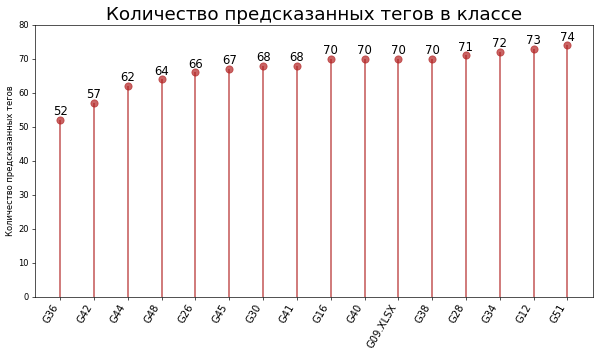

<Figure size 432x288 with 0 Axes>

In [ ]:
# Draw plot
fig, ax = plt.subplots(figsize=(12,6), dpi= 60)
ax.vlines(x=counts.index, ymin=0, ymax=counts['label'], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=counts.index, y=counts['label'], s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Количество предсказанных тегов в классе', fontdict={'size':22})
ax.set_ylabel('Количество предсказанных тегов')
ax.set_xticks(counts.index)
ax.set_xticklabels(counts['class'].astype(str).str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 80)

# Annotate
for row in counts.itertuples():
    ax.text(row.Index, row.label+.5, s=round(row.label, 2), horizontalalignment= 'center', 
            verticalalignment='bottom', fontsize=14)

plt.show()
plt.savefig('количество предсказанных тегов в классе_without g30.png')
# plt.axvline(counts['label'].mean())

In [ ]:
df['label'].nunique()

In [ ]:
a = df.groupby(['label'])['confidence'].mean().reset_index(drop=False)

a = a.rename(columns={"confidence":"Mean confidence"})
a
# a.sort_values('confidence')

In [ ]:
b = df.groupby(['label'])['confidence'].median().reset_index(drop=False)
b = b.rename(columns={"confidence":"Median confidence"})
b

In [ ]:
common_confidence = pd.merge(a, b, on = 'label')
common_confidence.sort_values('Mean confidence')

In [ ]:
percentage_norm_conf = len(common_confidence[common_confidence['Mean confidence'] < 0.75])/len(common_confidence)
percentage_norm_conf

0.9397590361445783

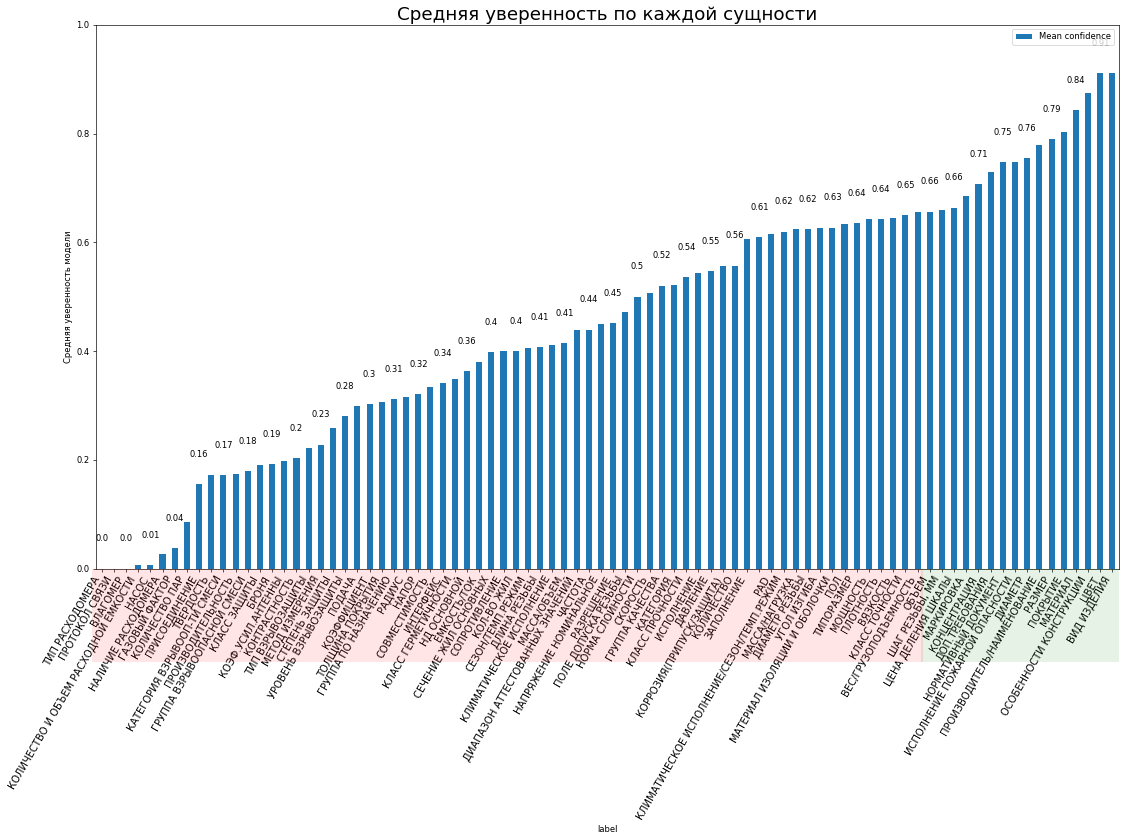

In [ ]:
import matplotlib.patches as patches

common_confidence.sort_values('Mean confidence', inplace=True)
common_confidence.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(22,12), dpi= 60)
common_confidence.plot(x="label", y=["Mean confidence"], kind="bar", ax=ax)

for i, cty in enumerate(common_confidence['Mean confidence']):
  if i%2==0:
    ax.text(i, cty+0.05, round(cty, 2), horizontalalignment='center')

# Title, Label, Ticks and Ylim
ax.set_title('Средняя уверенность по каждой сущности', fontdict={'size':22})
ax.set(ylabel='Средняя уверенность модели', ylim=(0, 1))
plt.xticks(common_confidence.index, common_confidence['label'].str.upper(), rotation=60, horizontalalignment='right', fontsize=12)

# Add patches to color the X axis labels
p1 = patches.Rectangle((.75, -0.005), width=.15, height=.13, alpha=.1, facecolor='green', transform=fig.transFigure)
p2 = patches.Rectangle((.122, -0.005), width=.630, height=.13, alpha=.1, facecolor='red', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.savefig('средняя_уверенность_по тегу_fixed.png')

In [ ]:
means = df.groupby(['class'])['confidence'].mean().reset_index(drop=False)
means = means.rename(columns={"confidence":"Mean confidence"})
means

In [ ]:
medians = df.groupby(['class'])['confidence'].median().reset_index(drop=False)
medians = medians.rename(columns={"confidence":"Median confidence"})
medians

In [ ]:
common_m_class = pd.merge(means, medians, on = 'class')
common_m_class.sort_values('Mean confidence')
common_m_class.reset_index(inplace=True)

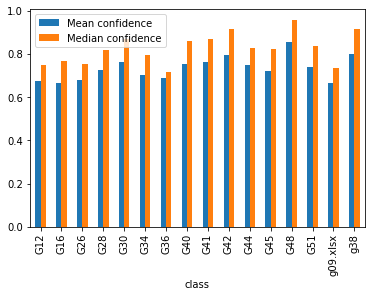

In [ ]:
common_m_class.plot(x="class", y=["Mean confidence", "Median confidence"], kind="bar")
plt.savefig('mean and median conf_old_without g30.png')

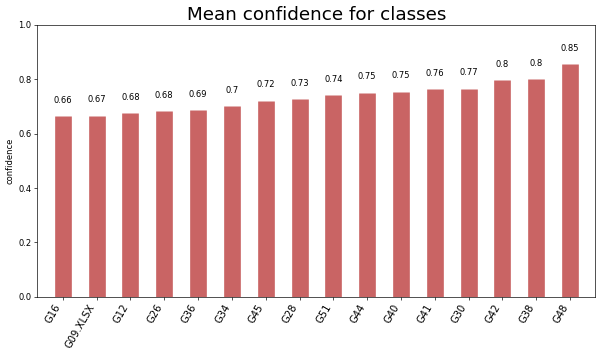

In [ ]:
common_m_class.sort_values('Mean confidence', inplace=True)
common_m_class.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(12,6), dpi= 60)
ax.vlines(x=common_m_class.index, ymin=0, ymax=common_m_class['Mean confidence'], color='firebrick', alpha=0.7, linewidth=20)

for i, cty in enumerate(common_m_class['Mean confidence']):
    ax.text(i, cty+0.05, round(cty, 2), horizontalalignment='center')

# Title, Label, Ticks and Ylim
ax.set_title('Mean confidence for classes', fontdict={'size':22})
ax.set(ylabel='confidence', ylim=(0, 1))
plt.xticks(common_m_class.index, common_m_class['class'].str.upper(), rotation=60, horizontalalignment='right', fontsize=12)

plt.savefig('bar conf_without g30.png')
plt.show()

75% - это минимум рэйт для точности распознавания сущности, чтобы сущность попала в хранилище в качестве атрибута материала или задействовалась в поиске в качестве искомого атрибута. Ниже график, с процент слов, распознанных моделью, уверенность модели в которых составляет более 75% в каждом классе

In [ ]:
a = df[df['confidence']>0.75].groupby(['class'])['word'].count().reset_index()

In [ ]:
b = df.groupby(['class'])['word'].count().reset_index()

In [ ]:
forpercent = pd.merge(a, b, on = 'class')
forpercent['percent'] = forpercent['word_x']/forpercent['word_y'] 
forpercent.sort_values('percent', inplace=True)
forpercent.reset_index(inplace=True)

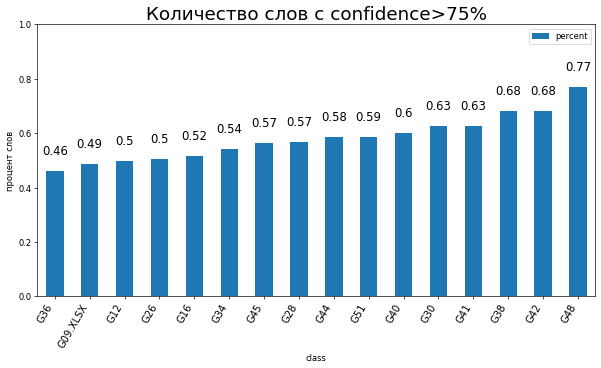

In [ ]:

# Draw plot
fig, ax = plt.subplots(figsize=(12,6), dpi= 60)
forpercent.plot(x="class", y=["percent"], kind="bar", ax=ax)

# Title, Label, Ticks and Ylim
ax.set_title('Количество слов с confidence>75%', fontdict={'size':22})
ax.set_ylabel('процент слов')
ax.set_xticks(forpercent.index)
ax.set_xticklabels(forpercent['class'].astype(str).str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 1)

# Annotate
for row in forpercent.itertuples():
    ax.text(row.Index, row.percent+.05, s=round(row.percent, 2), horizontalalignment= 'center', 
            verticalalignment='bottom', fontsize=14)
plt.savefig('numb of words conf>0.75.png')